In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ssd
import scipy.signal as signal
import imp # for module reloading
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.special as special
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.synchronization as pll

## ADC

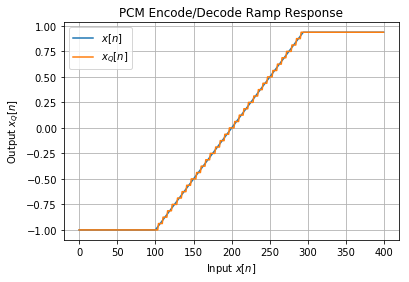

In [8]:
figure(figsize=(6,4))
Nb = 5
n = arange(0,400)
# Complete ******
x = 4*n/400-2
# Add clipping to x as in a real ADC
x = x.clip(-1,1 - 1/(2**(Nb - 1)))
xbits = dc.PCM_encode(x,Nb)
xq = dc.PCM_decode(xbits,Nb)
plot(n,x)
plot(n,xq)
title(r'PCM Encode/Decode Ramp Response')
xlabel(r'Input $x[n]$')
ylabel(r'Output $x_Q[n]$')
legend((r'$x[n]$',r'$x_Q[n]$'),loc='best')
grid();

In [4]:
print('Resolution: ', 2**(-5))

Resolution:  0.03125


## Stream de bits (arquivo .wav)

In [6]:
fs,m1 = ssd.from_wav('Houston we have a Problem.wav');
ssd.to_wav('yp2.wav', 44100, m1[:, 1]);
N  = size(m1[:, 1]);
Ns = 16;
Fc1  = 4;
Audio('yp2.wav')

### Nível de ruído adicionado ao sinal

In [18]:
EbNo = 50;
x  = m1[:,1];
xe = dc.PCM_encode(x, Ns);
xer = dc.AWGN_chan(xe, EbNo);
m1_hat = dc.PCM_decode(xer, Ns);

Text(0.5,0,'Normalized Frequency ($f/R_b$)')

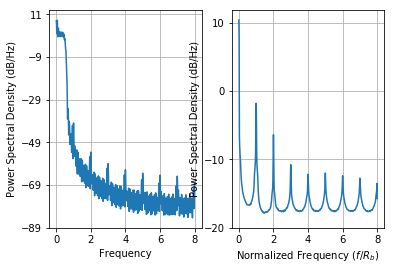

In [19]:
x, b = dc.NRZ_bits2(xe, Ns, 'src');
subplot(121)
psd(x, 2**10, 16);
subplot(122)
psd(xer, 2**10, 16);
xlabel(r'Normalized Frequency ($f/R_b$)')

In [20]:
y_demod = m1_hat;
ssd.to_wav('yp2.wav', 44100, y_demod);
Audio('yp2.wav')

### Densidade espectral de potência 

In [130]:
#dc.NRZ_bits(N_bits, Ns, pulse='rect', alpha=0.25, M=6)
xbb1, b, d = dc.NRZ_bits(N, Ns, 'src');
n = arange(0, len(xbb1));
# Translate baseband to fc1/fs = 4.0/16
# Relative to Ns = 16 samps/bit & Rb = 1 bps
xc1 = xbb1*exp(1j*2*pi*Fc1/Ns*n)

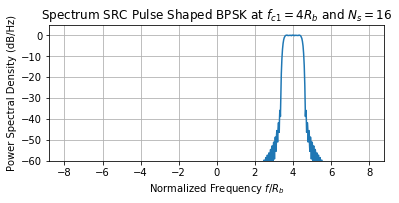

In [131]:
figure(figsize=(6,2.5))
psd(xc1,2**10,16);
ylim([-60,5])
xlabel(r'Normalized Frequency $f/R_b$')
title(r'Spectrum SRC Pulse Shaped BPSK at $f_{c1} \
      = 4R_b$ and $N_s = 16$');

## Exemplo de simulação BPSK banda-passante

In [22]:
Nstart = 500000;
Nsamp  = 60000;
fs, m0 = ssd.from_wav('Houston we have a Problem.wav');
m0 = m0[Nstart:Nstart+Nsamp, 1];
ssd.to_wav('yp2.wav', 44100, m0);
Audio('yp2.wav')

In [51]:
EbN0_dB = 7;

# Choose the random bits or PCM encoded speech
# Uncomment the line below to select random bits
# Enter the number of bits simulated, here 10000
#Nbits = 10000
#x,b,a_in = dc.NRZ_bits(Nbits,Ns,'src')
#
# Uncomment the following two lines to select encoded speech
a_in = dc.PCM_encode(m0, 8)
x,b  = dc.NRZ_bits2(a_in, Ns, 'src')

# AWGN channel set via EbNo_dB at top
y = dc.cpx_AWGN(x,EbN0_dB,Ns)

# Introduce frequency error into the baseband BPSK signal
# setting Df = 0.012 makes actual Df = 0.012*Rb
n  = arange(0,len(x))
Df = 0.12;
y *= exp(1j*2*pi*Df/Ns*n) # Df = 0.012*Rb or 1.2% of Rb

# Matched filter
z = signal.lfilter(b,1,y)
# Sample MF output at once per bit
# The third argument controls the sampling phase or offset mod Ns
zd = ssd.downsample(z,Ns,0)

# Carrier phase tracking
# DD carrier phase sync: 2<=>BPSK, 0.05=loop BW/Rb,0.70=loop damping
zz,a_hat,e_phi,theta_hat = pll.DD_carrier_sync(zd,2,0.1,0.707)

# Estimate the bit error probability (BEP)
Nbits,Nerrors = dc.BPSK_BEP(2.*a_in-1,a_hat.real)
print('BEP: Nbits = %d, Nerror = %d, Pe_est = %1.3e' % \
      (Nbits, Nerrors, Nerrors/Nbits))

# Calculate the corresponding theoretical BEP, but
# note this is ideal as the carrier phase tracking is
# not modeled.
Pe_thy = 1/2*special.erfc(sqrt(10**(EbN0_dB/10)))
print('Pe_thy = %1.3e' % Pe_thy)

kmax =  0, taumax = 12
BEP: Nbits = 479988, Nerror = 757, Pe_est = 1.577e-03
Pe_thy = 7.727e-04


In [52]:
zz[:5]

array([ 0.0001422 +5.47443703e-05j, -0.00018487+1.86480559e-03j,
       -0.00761735+1.17159520e-03j,  0.00825282-8.68626564e-03j,
       -0.00181256+1.94150560e-02j])

In [53]:
m0_hat = dc.PCM_decode(1-(1+a_hat[12:-4].real)//2,8)
ssd.to_wav('m0_hat.wav', 44100, m0_hat)
Audio('m0_hat.wav')

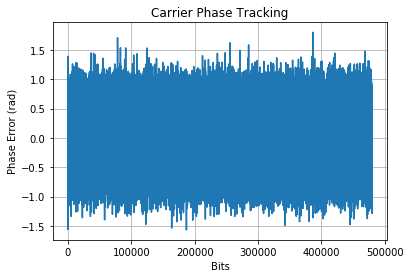

In [54]:
plot(e_phi)
ylabel(r'Phase Error (rad)')
xlabel(r'Bits')
title(r'Carrier Phase Tracking')
grid();

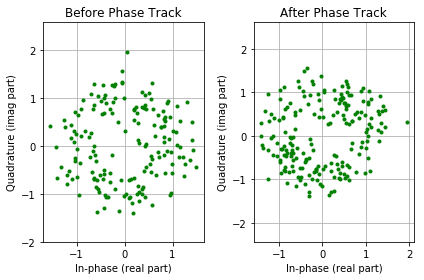

In [55]:
Nstart = 30
Nbits = 200
subplot(1,2,1)
plot(zd[Nstart:Nbits].real,zd[Nstart:Nbits].imag,'g.'); axis('equal');
xlabel(r'In-phase (real part)')
ylabel(r'Quadrature (imag part)')
title(r'Before Phase Track')
grid()
subplot(1,2,2)
plot(zz[Nstart:Nstart+Nbits].real,zz[Nstart:Nstart+Nbits].imag,'g.'); axis('equal');
xlabel(r'In-phase (real part)')
ylabel(r'Quadrature (imag part)')
title(r'After Phase Track')
grid();
tight_layout()

In [64]:
EbN0_dB = 20;

a_in = dc.PCM_encode(m0, 8)
x,b  = dc.NRZ_bits2(a_in, Ns, 'src')

# AWGN channel set via EbNo_dB at top
y = dc.cpx_AWGN(x,EbN0_dB,Ns)

# Introduce frequency error into the baseband BPSK signal
# setting Df = 0.012 makes actual Df = 0.012*Rb
n  = arange(0,len(x))
Df = 0.12;
y *= exp(1j*2*pi*Df/Ns*n) # Df = 0.012*Rb or 1.2% of Rb

# Incorporate adjacent channel signals by
# uncommenting the next five lines
f_adj = 1.05
x_lo,b,d_lo = dc.NRZ_bits(len(a_in),Ns,'src')
x_hi,b,d_hi = dc.NRZ_bits(len(a_in),Ns,'src')
y = y + x_lo*exp(-1j*2*pi*f_adj/Ns*n) \
      + x_hi*exp(1j*2*pi*f_adj/Ns*n)

# Matched filter
z = signal.lfilter(b,1,y)
# Sample MF output at once per bit
# The third argument controls the sampling phase or offset mod Ns
zd = ssd.downsample(z,Ns,0)

# Carrier phase tracking
# DD carrier phase sync: 2<=>BPSK, 0.05=loop BW/Rb,0.70=loop damping
zz,a_hat,e_phi,theta_hat = pll.DD_carrier_sync(zd,2,0.5,0.707)

# Estimate the bit error probability (BEP)
Nbits,Nerrors = dc.BPSK_BEP(2.*a_in-1,a_hat.real)
print('BEP: Nbits = %d, Nerror = %d, Pe_est = %1.3e' % \
      (Nbits, Nerrors, Nerrors/Nbits))

# Calculate the corresponding theoretical BEP, but
# note this is ideal as the carrier phase tracking is
# not modeled.
Pe_thy = 1/2*special.erfc(sqrt(10**(EbN0_dB/10)))
print('Pe_thy = %1.3e' % Pe_thy)

kmax =  1, taumax = 12
BEP: Nbits = 479988, Nerror = 57481, Pe_est = 1.198e-01
Pe_thy = 1.044e-45


In [65]:
m0_hat = dc.PCM_decode(1-(1+a_hat[12:-4].real)//2,8)
ssd.to_wav('m0_hat.wav', 44100, m0_hat)
Audio('m0_hat.wav')

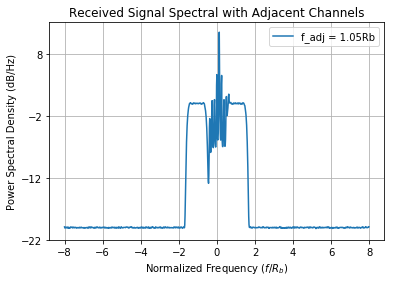

In [66]:
psd(y,2**10,16);
xlabel(r'Normalized Frequency ($f/R_b$)')
title(r'Received Signal Spectral with Adjacent Channels')
legend(('f_adj = %1.2fRb' % f_adj,),loc='best')

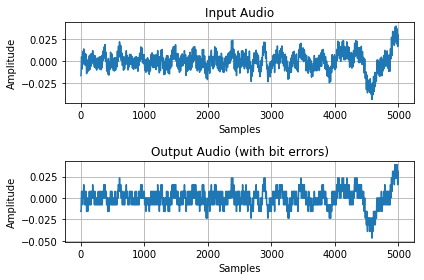

In [163]:
subplot(211)
plot(m0[:5000])
#ylim([-1,1])
title(r'Input Audio')
ylabel(r'Amplitude')
xlabel(r'Samples')
grid();
subplot(212)
plot(m0_hat[:5000])
title(r'Output Audio (with bit errors)')
ylabel(r'Amplitude')
xlabel(r'Samples')
grid();
tight_layout()